# TODO LIST

- [x] Choose Amsterdam / Rotterdam via parameter
- [x] Add Lags for remaining districts
- [x] Replace `lagged` variables with `diff`
- [x] Look-ahead values (e.g. 1 min 5 min 10 min 30 min)
  - [ ] Prediction function should be tunable
- [x] Confusion Matrix per bin - find out model inaccuracies
- [x] Add `LightGBM` model
- [ ] Benchmark accuracy (classification report), train-time (...), inference-time (...)


In [5]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from xgboost import XGBClassifier

In [21]:
df = pd.read_parquet("data/final/points_per_district_full.parquet.gzip")

In [22]:
df = (
    df.pivot_table(
        index="timestamp", columns="district_id", values="crowd", aggfunc="sum"
    )
    .ffill()
    .bfill()
    .astype(np.uint16)
    .sort_values(by="timestamp")
    .reset_index()
)

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.head()

district_id,timestamp,Bedrijvenpark Noord-West,Bedrijventerrein Schieveen,Botlek,Charlois,Delfshaven,Feijenoord,Hillegersberg-Schiebroek,Hoek van Holland,Hoogvliet,...,Noord,Overschie,Pernis,Prins Alexander,Rivium,Rotterdam Centrum,Spaanse Polder,Vondelingenplaat,Waalhaven,Ĳsselmonde
0,2024-06-18 06:21:58,18,8,1,327,520,496,513,15,4,...,391,37,1,238,1,732,46,1,10,225
1,2024-06-18 06:23:00,18,8,1,328,520,497,512,15,4,...,390,37,1,238,1,730,46,1,10,225
2,2024-06-18 06:24:02,18,8,1,329,519,498,512,15,4,...,391,37,1,238,1,732,46,1,10,225
3,2024-06-18 06:25:04,18,8,1,329,519,499,512,15,4,...,391,37,1,238,1,734,46,1,10,225
4,2024-06-18 06:26:07,18,8,1,329,517,499,515,15,4,...,391,37,1,238,1,733,46,1,10,225


In [23]:
df.shape

(22265, 22)

## Feature Extraction

1. Binning
2. Feature Extraction
   1. Time-related Features
      1. Hour
      2. Minute
      3. Day of week
   2. Lagged Features
      1. 1-10 Minutes
      2. 15 Minutes
      3. 30 Minutes
      4. 60 Minutes
   3. Rolling Mean Features
      1. Mean
      2. Std
      3. Var
      4. Kurtosis
      5. Skewness
   4. Exponential Smoothing Features
      1. 5 Minutes
      2. 10 Minutes
      3. 15 Minutes
      4. 30 Minutes
      5. 60 Minutes
3. Cyclic Encoding


##### Binning


In [24]:
target_district = "Rotterdam Centrum"
target_column_name = f'{target_district.replace(" ", "_")}_c_lvl'

mean_crowd = df[target_district].mean()
std_crowd = df[target_district].std()

# Define bins based on mean and standard deviation
# bins = [
#     float("-inf"),
#     mean_crowd - 1.0 * std_crowd,
#     mean_crowd - 0.25 * std_crowd,
#     mean_crowd + 0.25 * std_crowd,
#     mean_crowd + 1.0 * std_crowd,
#     float("inf"),
# ]

bins = [
    float("-inf"),
    mean_crowd - 0.55 * std_crowd,
    mean_crowd + 0.55 * std_crowd,
    float("inf"),
]

# Define labels for the bins
labels = list(range(len(bins) - 1))

In [25]:
df[target_column_name] = pd.cut(
    df[target_district],
    bins=bins,
    labels=labels,
    include_lowest=True,
    ordered=True,
)

df.dropna(inplace=True)
df.shape

(22265, 23)

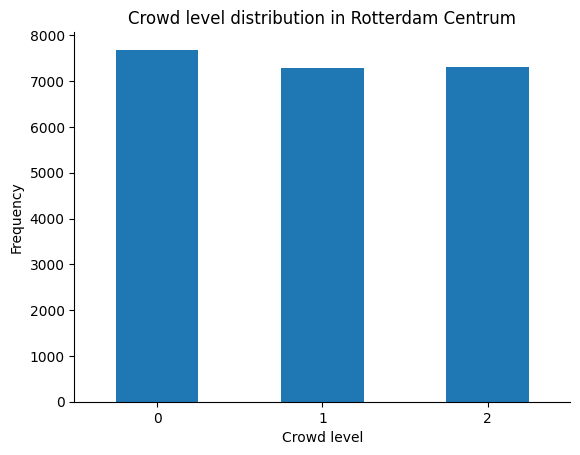

In [26]:
df[target_column_name].value_counts().sort_index().plot(
    kind="bar",
    rot=0,
    xlabel="Crowd level",
    ylabel="Frequency",
    title=f"Crowd level distribution in {target_district}",
)
plt.gca().spines[["top", "right"]].set_visible(False)
plt.show()

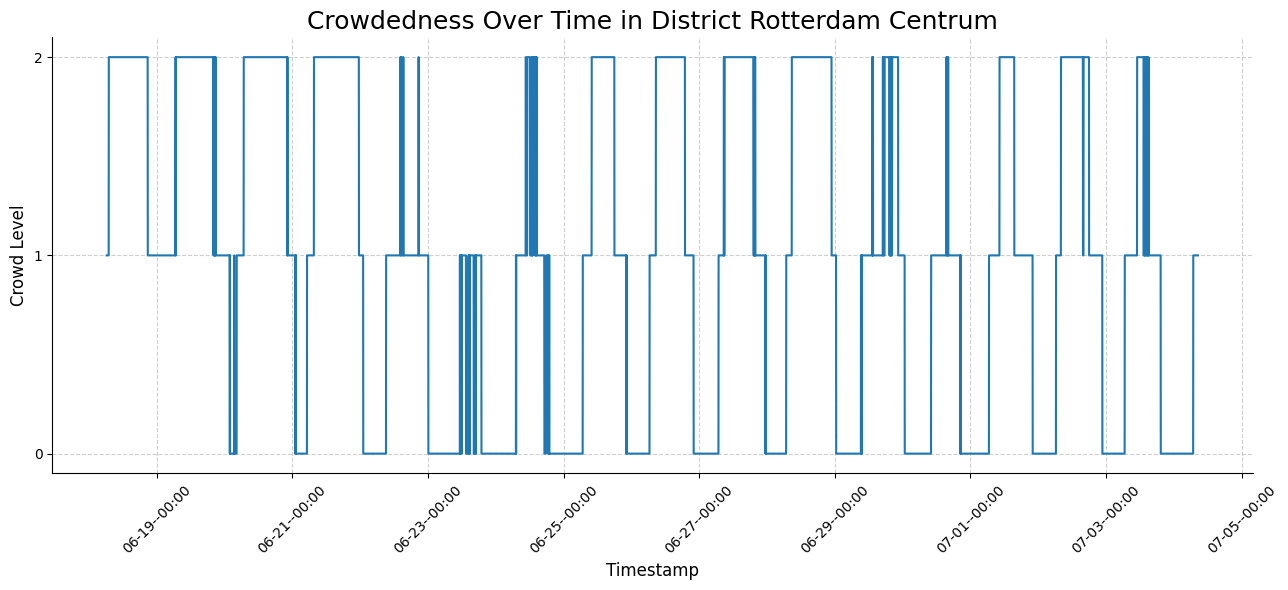

In [27]:
_, ax = plt.subplots(figsize=(13, 6))


ax.plot(
    df["timestamp"],
    df[target_column_name],
    linestyle="-",
    linewidth=1.5,
)

ax.set_title(f"Crowdedness Over Time in District {target_district}", fontsize=18)
ax.set_xlabel("Timestamp", fontsize=12)
ax.set_ylabel("Crowd Level", fontsize=12)
plt.gca().spines[["top", "right"]].set_visible(False)
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d--%H:%M"))

plt.xticks(rotation=45)
plt.yticks(df[target_column_name].unique())
plt.tight_layout()
# plt.savefig(f"figures/Crowdedness (Binned) {target_district}.png", dpi=150)
plt.show()

Time-related Feature Extraction


In [28]:
# Time-related features
time_related_features = {
    "hour": df["timestamp"].dt.hour.astype(np.uint8),
    "day_of_week": df["timestamp"].dt.day_of_week.astype(np.uint8),
    "minute": df["timestamp"].dt.minute.astype(np.uint8),
    "is_weekend": (df["timestamp"].dt.weekday >= 5).astype(np.uint8),
}

Lagged and Rolling Feature Extraction


In [29]:
lagged_features = {}
rolling_features = {}
exp_smoothing_features = {}
windows = [5, 10, 15, 30] + [60 * i for i in range(1, 7)] + [60 * 24]

for district in df.columns[1:-1]:
    lagged_features.update(
        {
            f"{district.replace(' ', '_')}_lag_{i}": df[district].shift(i).diff()
            for i in list(range(1, 11)) + [15, 30, 60]
        }
    )

    rolling_features.update(
        {
            f"{district.replace(' ', '_')}_rolling_{stat}_{window}": getattr(
                df[target_district].rolling(window=window), stat
            )()
            for window in windows
            for stat in ["mean", "std", "var", "skew", "kurt"]
        }
    )

    exp_smoothing_features.update(
        {
            f"{district.replace(' ', '_')}_ema_{window}": df[target_district]
            .ewm(span=window, adjust=True)
            .mean()
            for window in windows
        }
    )

In [30]:
lagged_df = (
    pd.concat(
        [
            # After Feature Extraction we can drop the original target column
            df.drop(columns=target_district),
            pd.DataFrame(lagged_features),
            pd.DataFrame(rolling_features),
            pd.DataFrame(exp_smoothing_features),
            pd.DataFrame(time_related_features),
        ],
        axis=1,
    )
    .set_index("timestamp")
    .dropna()
)

#### Data Splitting


In [31]:
X = lagged_df.drop(columns=target_column_name)
y = lagged_df[target_column_name]

X.shape, y.shape

((20826, 1683), (20826,))

#### Correlation Analysis

(Still in Progress)


In [32]:
# cm = X.corr(method="kendall", numeric_only=True).abs()
# upper = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))

# high_corr = [col for col in upper.columns if any(upper[col] > 0.8)]
# X.drop(columns=high_corr, inplace=True)

### Model Training

1. Pipeline Construction
2. Hyperparameter Tuning
3. Time Series Cross Validation


In [33]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)

In [34]:
print(
    f"TRAIN: {X_train.shape}, {y_train.shape}, \nTEST: {X_test.shape}, {y_test.shape}"
)

TRAIN: (14578, 1683), (14578,), 
TEST: (6248, 1683), (6248,)


#### Pipeline Construction


In [35]:
num_features = X_train.select_dtypes(include=np.number).columns.tolist()

In [36]:
def build_pipe(clf):
    preprocessor = ColumnTransformer(
        transformers=[
            ("scaler", StandardScaler(), num_features),
        ],
        remainder="passthrough",
    )

    return Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", clf),
        ]
    )


# Pre-tuned classifier from Grid Search Results
xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    gamma=0,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=10,
    reg_lambda=0.5,
    n_jobs=-1,
    random_state=42,
)

lgb = LGBMClassifier(
    boosting_type="gbdt",
    objective="multiclass",
    force_col_wise=True,
    num_leaves=3,
    max_depth=10,
    reg_lambda=0.7,
    colsample_bytree=0.5,
    learning_rate=0.01,
    reg_alpha=0.3,
    subsample=0.5,
    n_jobs=-1,
    verbosity=0,
    random_state=42,
)

# pipeline = build_pipe(xgb)
pipeline = build_pipe(lgb)

##### Grid Search


In [37]:
tuned = True

In [38]:
ts_cv = TimeSeriesSplit(n_splits=5)
scoring = {
    "accuracy": make_scorer(balanced_accuracy_score),
    "f1_micro": make_scorer(f1_score, average="micro"),
}

No need to run Grid Search - Results are stored

Skip the next 3 cells


In [44]:
# TODO: Refactor this to enchance readability

if not tuned:
    param_grid = {
        # "classifier__n_estimators": np.arange(50, 300, 50),
        # "classifier__max_depth": np.arange(3, 10, 2),
        "classifier__learning_rate": [0.01, 0.1, 0.3],
        "classifier__subsample": [0.5, 0.7, 1.0],
        "classifier__colsample_bytree": [0.5, 0.8, 1.0],
        "classifier__reg_alpha": np.linspace(0.3, 1.0, 3).round(1),
        # "classifier__reg_lambda": np.linspace(0.3, 1.0, 3).round(1)
    }
    print(f"====== Performing Grid Search ======\n")

    param_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=ts_cv,
        scoring=scoring,
        refit="f1_micro",
        n_jobs=1,
        verbose=1,
        error_score="raise",
    )
    param_search.fit(X_train, y_train)

    print("\n====== Hyperparameter Tuning Results ======")
    print(f"Best score: {param_search.best_score_:.3f}")
    print(f"Best parameters:")
    for key, value in param_search.best_params_.items():
        print(f"    - {key.split('__')[-1]}: {value}")

    best_model = param_search.best_estimator_
    best_model.fit(X_train, y_train)

    print("\n====== Cross-Validation Results ======")
    for key, value in param_search.cv_results_.items():
        (
            print(
                f"{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
            )
            if key.startswith(("mean_test", "test"))
            else None
        )
else:
    print("Model is pre-tuned")
    best_model = pipeline
    best_model.fit(X_train, y_train)

Model is pre-tuned


In [45]:
# # Bayesian Optimization
# bayes_space = {}

# bayes_search = BayesSearchCV(
#     pipeline,
#     search_spaces=bayes_space,
#     scoring="f1_micro",
#     cv=ts_cv,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42,
# )

# bayes_search.fit(X_train, y_train)
# print(f"Best Params from Bayesian Optimization: {bayes_search.best_params_}")

In [46]:
cv_result = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=ts_cv,
    scoring=scoring,
    error_score="raise",
)

print("\n====== Train Set ======")
for key, value in cv_result.items():
    (
        print(
            f"CV-{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )


====== Train Set ======
CV-Test Accuracy: 0.981 ± 0.016
CV-Test F1 Micro: 0.987 ± 0.005


In [47]:
cv_results_test = cross_validate(
    best_model,
    X_test,
    y_test,
    cv=ts_cv,
    scoring=scoring,
    error_score="raise",
)
print("\n====== Test Set ======")
for key, value in cv_results_test.items():
    (
        print(
            f"CV-{key.replace('_', ' ').title()}: {value.mean():.3f} ± {value.std():.3f}"
        )
        if key.startswith(("mean_test", "test"))
        else None
    )

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [48]:
importances = (
    pd.DataFrame(data=[X_train.columns, best_model[1].feature_importances_])
    .T.rename(
        {
            0: "feature",
            1: "importance",
        },
        axis=1,
    )
    .sort_values(by="importance")
)

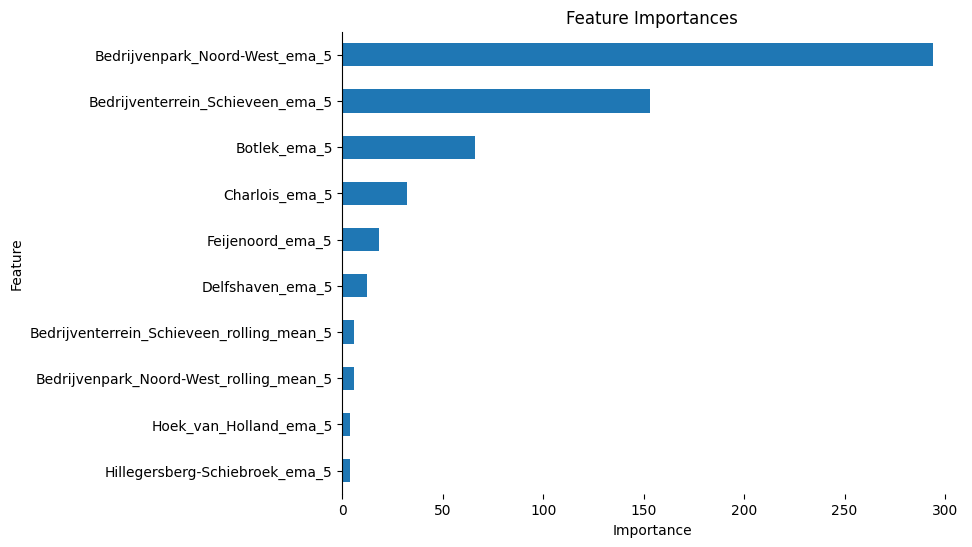

In [49]:
importances.tail(10).plot.barh(x="feature", y="importance", figsize=(8, 6))
plt.title("Feature Importances")
plt.legend().set_visible(False)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.gca().spines[["right", "bottom", "top"]].set_visible(False)
plt.show()
plt.show()

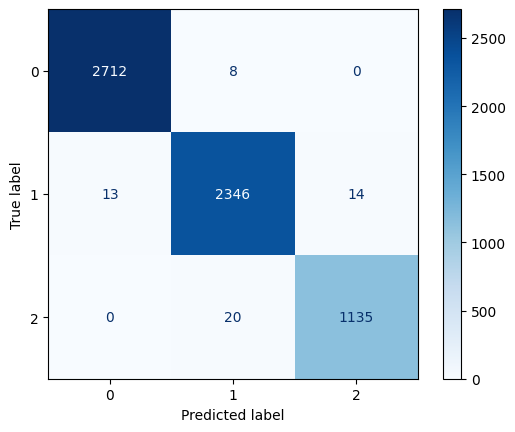

In [50]:
y_pred = best_model.predict(X_test)
_ = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")

In [51]:
print(
    classification_report(
        y_test,
        y_pred,
        digits=3,
        target_names=["low", "medium", "high"],
    )
)
print("============================================")
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred):.2%}")

              precision    recall  f1-score   support

         low      0.995     0.997     0.996      2720
      medium      0.988     0.989     0.988      2373
        high      0.988     0.983     0.985      1155

    accuracy                          0.991      6248
   macro avg      0.990     0.989     0.990      6248
weighted avg      0.991     0.991     0.991      6248

Balanced Accuracy Score: 98.95%


#### Cross-Validation of the Testing Set:

- XGBClassifier
  - 5 minutes
    - Accuracy: 0.944 ± 0.020
    - F1 Micro: 0.944 ± 0.020
  - 10 minutes
    - Accuracy: 0.867 ± 0.097
    - F1 Micro: 0.867 ± 0.097
  - 30 minutes
    - Accuracy: 0.829 ± 0.119
    - F1 Micro: 0.829 ± 0.119
  - 60 minutes
    - Accuracy: 0.644 ± 0.212
    - F1 Micro: 0.644 ± 0.212
- LGBMClassifier
  - 5 minutes
    - Accuracy: 0.770 ± 0.141
    - F1 Micro: 0.916 ± 0.106
    - Balanced Accuracy Score: 95.91%
  - 10 minutes
    - Accuracy:
    - F1 Micro:
  - 30 minutes
    - Accuracy:
    - F1 Micro:
  - 60 minutes
    - Accuracy: 0.664 ± 0.134
    - F1 Micro: 0.750 ± 0.153
